In [1]:
import tensorflow as tf
# encoding=utf8  
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import pickle

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Step 1: Download the data.
url = 'http://mattmahoney.net/dc/'

# 下载数据集
def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    # 获取文件相关属性
    statinfo = os.stat(filename)
    # 比对文件的大小是否正确
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

# 单词表
words = read_data(filename)

# Data size
print('Data size', len(words))

Found and verified text8.zip
Data size 17005207


In [3]:
# Step 2: Build the dictionary and replace rare words with UNK token.
# 只留50000个单词，其他的词都归为UNK
vocabulary_size = 50000

def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    # extend追加一个列表
    # Counter用来统计每个词出现的次数
    # most_common返回一个TopN列表，只留50000个单词包括UNK  
    # c = Counter('abracadabra')
    # c.most_common()
    # [('a', 5), ('r', 2), ('b', 2), ('c', 1), ('d', 1)]
    # c.most_common(3)
    # [('a', 5), ('r', 2), ('b', 2)]
    # 前50000个出现次数最多的词
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    # 生成 dictionary，词对应编号, word:id(0-49999)
    # 词频越高编号越小
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    # data把数据集的词都编号
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    # 记录UNK词的数量
    count[0][1] = unk_count
    # 编号对应词的字典
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

# data 数据集，编号形式
# count 前50000个出现次数最多的词
# dictionary 词对应编号
# reverse_dictionary 编号对应词
data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])


Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5237, 3084, 12, 6, 195, 2, 3136, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [4]:
data_index = 0
# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    # [ skip_window target skip_window ]
            # [ skip_window target skip_window ]
                    # [ skip_window target skip_window ]
            
#     [0 1 2 3 4 5 6 7 8 9 ...]
#            t     i  
    # 循环3次
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # 获取batch和labels
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        # 循环2次，一个目标单词对应两个上下文单词
        #num_skips 在定义窗口大小和方向时已确定
        for j in range(num_skips):
            while target in targets_to_avoid:
                # 可能先拿到前面的单词也可能先拿到后面的单词
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    # 回溯3个词。因为执行完一个batch的操作之后，data_index会往右多偏移span个位置
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

# 打印sample data
batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])


3084 originated -> 5237 anarchism
3084 originated -> 12 as
12 as -> 3084 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


In [5]:
# Step 4: Build and train a skip-gram model.
batch_size = 128
# 词向量维度
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
# 从0-100抽取16个整数，无放回抽样
valid_examples = np.random.choice(valid_window, valid_size, replace=False) 
# 负采样样本数
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()
with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
#     with tf.device('/cpu:0'):
        # 词向量
        # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    # embedding_lookup(params,ids)其实就是按照ids顺序返回params中的第ids行
    # 比如说，ids=[1,7,4],就是返回params中第1,7,4行。返回结果为由params的1,7,4行组成的tensor
    # 提取要训练的词
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the noise-contrastive estimation(NCE) loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,   
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    # 抽取一些常用词来测试余弦相似度
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    # valid_size == 16
    # [16,1] * [1*50000] = [16,50000]
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [6]:
# Step 5: Begin training.
num_steps = 100001
final_embeddings = []

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        # 获取一个批次的target，以及对应的labels，都是编号形式的
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        # 计算训练2000次的平均loss
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0
    
        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            # 计算验证集的余弦相似度最高的词
            for i in xrange(valid_size):
                # 根据id拿到对应单词
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                # 从大到小排序，排除自己本身，取前top_k个值
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    # 训练结束得到的词向量
    final_embeddings = normalized_embeddings.eval()


Initialized
Average loss at step  0 :  268.10687255859375
Nearest to UNK: replicant, obelix, octane, andorra, reasoner, ame, extravagance, connected,
Nearest to during: cromarty, pontifex, antecedent, kauffman, schaff, bhfiann, expiration, sympathies,
Nearest to i: recursively, emulating, piers, assertions, sgh, fills, cart, vestry,
Nearest to most: renditions, golem, rensselaer, wahhabis, violation, airplane, sprint, triumphantly,
Nearest to known: electric, rockford, nfs, roof, moose, revue, remarried, karelian,
Nearest to were: eater, beggars, athlete, morte, carneiro, after, experienced, correspond,
Nearest to eight: skiers, devotions, infinity, entails, dismayed, useable, cinema, loc,
Nearest to would: bore, merdeka, railroad, novello, organist, blogs, codenamed, strengths,
Nearest to world: ascertained, nhs, propagation, explore, timber, env, feng, thicknesses,
Nearest to american: cleopatra, endosperm, collectors, rulership, epoxy, chimney, khoikhoi, mendel,
Nearest to war: pare

Average loss at step  82000 :  4.761817681074143
Average loss at step  84000 :  4.739814971089363
Average loss at step  86000 :  4.772907150268555
Average loss at step  88000 :  4.731499266982079
Average loss at step  90000 :  4.742863519430161
Average loss at step  92000 :  4.676385418653489
Average loss at step  94000 :  4.7212988830804825
Average loss at step  96000 :  4.69265198123455
Average loss at step  98000 :  4.597028420329094
Average loss at step  100000 :  4.6982656434774395
Nearest to UNK: agouti, dasyprocta, ursus, cebus, callithrix, circ, mitral, ssbn,
Nearest to during: in, after, within, before, at, when, circ, heterochromatin,
Nearest to i: we, circ, assertions, you, they, dasyprocta, phimosis, scalia,
Nearest to most: more, many, some, integrate, microsite, realpolitik, trinomial, violation,
Nearest to known: such, used, well, kapoor, vma, cocoa, thaler, akh,
Nearest to were: are, have, was, had, be, ramps, is, while,
Nearest to eight: seven, six, nine, five, four, t

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


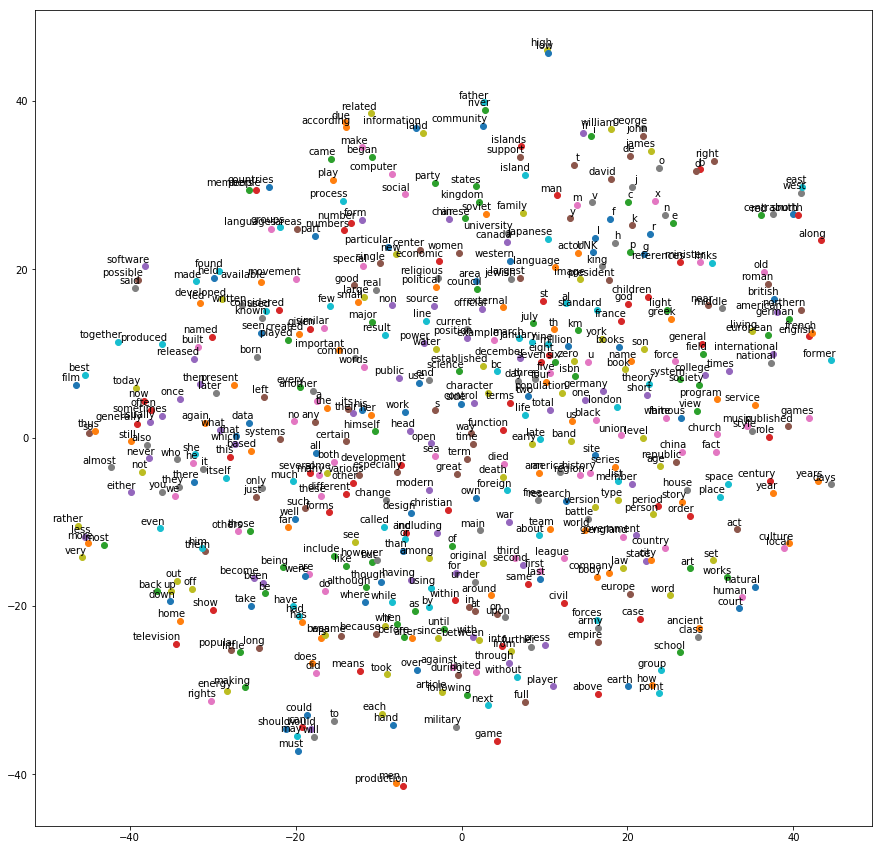

In [9]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    # 设置图片大小
    plt.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    %matplotlib inline

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')# mac：method='exact'
    # 画500个点
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")

In [10]:
with tf.Session() as session:
    valid_word = "name"
    valid_examples = dictionary[valid_word]
    valid_dataset = tf.constant([valid_examples], dtype=tf.int32)
    valid_embeddings = tf.nn.embedding_lookup(final_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, final_embeddings, transpose_b=True)
    sim = similarity.eval()

    top_k = 8  # number of nearest neighbors
    nearest = (-sim[0]).argsort()[1:top_k + 1]# 排除自己本身，从小到大排序
    log_str = "Nearest to %s:" % valid_word
    for k in xrange(top_k):
        close_word = reverse_dictionary[nearest[k]]
        log_str = "%s %s," % (log_str, close_word)
    print(log_str)

Nearest to name: bckgr, rest, calculus, perjury, understanding, obliged, leno, correct,


In [7]:
with open('cnn-text-classification-tf-master/w2v_dict.pickle', 'wb') as f:
    pickle.dump(dictionary, f)
    
with open('cnn-text-classification-tf-master/embeddings.pickle', 'wb') as f:
    pickle.dump(final_embeddings, f)
    

In [16]:
print(final_embeddings.shape)
# print(final_embeddings[0])

(50000, 128)


In [14]:
for i in dictionary:
    print(i)

tyrrhenian
equator
plumbing
tripping
ceres
caller
dissident
diglossia
verses
claiming
shepherds
sonic
repertory
gniezno
librivox
thee
fontsize
deoxyribose
masque
blaming
democritus
bass
filipino
afi
sive
marcian
long
vanishing
maxillofacial
eloquent
gdansk
deport
touchdowns
lookups
monophysite
quiet
ajmer
mandated
remarkable
orderly
psoriasis
jati
tungsten
yahoo
ayahuasca
alces
composite
height
daemen
brahmins
generalitat
trace
lms
butchers
occidentalis
grudge
mitochondrion
andrea
deliverance
strelitz
remnants
caused
detergent
enjoined
shamash
zeppo
racehorse
radiotelephone
stanhope
bile
prosecution
candles
peter
yeo
crested
toynbee
masorti
qi
patrice
fath
deane
bittersweet
consecrate
archive
borrelly
margaret
perplexed
headwaters
doors
chicks
detachments
leitch
kruger
chair
daunting
gamete
northwards
nahum
propagation
millennial
alluvial
gbc
supplanted
latinate
demetrius
ayrshire
etruscans
addition
compositions
alchemy
solent
enzymatic
shaftesbury
selkirk
gneisenau
deepening
rature
ri

strides
disposable
tasking
germanic
here
isometry
joke
finnegan
map
excommunicate
annuity
dashing
cardano
colombia
inducted
appeared
presented
inspirational
overtaken
scantily
salam
swallow
hallucinations
flaming
yield
hammered
velvet
nightingale
cheung
posthumous
legendary
practices
ssc
watercolors
distracted
waterproof
doubleday
subdued
smog
tuireadh
irv
stenella
symbolised
promoter
romance
carver
arterial
ejecta
invalidate
publique
jeju
brenda
aluma
druids
totals
footwear
ipcc
shameful
pinchcliffe
ar
backbench
cannery
viewable
panoramic
inferences
edgard
luck
dmitry
paperback
precise
voyages
classifies
comm
girth
aerosmith
bargain
calderas
chakras
martyrdom
oscilloscope
mosquitia
faithfully
diy
plotted
rcaf
toole
wet
riff
backgammon
reykjav
baths
maturity
marriages
bowles
blackboard
bmp
narrators
crossings
gladio
egon
laches
haag
teeth
norad
britons
capra
initialism
mall
repressed
cardiomyopathy
appearance
grandsons
biggest
twenties
laird
typology
concentrating
lodges
interchangeabl

orcinus
aztec
larp
transboundary
fatigue
loki
opposing
guarantees
sabre
jotham
looser
flipper
lint
alamos
chrysostom
dingo
colonies
confer
nehru
wetlands
soundhole
zia
cyclones
scaled
bs
heisei
flaminius
sandy
mycenae
chauvinism
lanka
commission
catv
demonolatry
moths
mmo
mobutu
poachers
timetable
quantization
diab
pershing
lob
torment
shadowed
paralyzed
paranormal
underpinning
calamity
nay
strom
veda
moves
pebble
rewrite
arabia
specialized
longbowmen
ebro
cartoonist
ends
juanita
consenting
journal
agonists
oxidized
redistribution
roommate
fueling
placenta
english
holographic
doorway
egyptologist
moselle
farragut
breaded
theism
pareto
molotov
instantaneous
censorware
prudence
jscript
actually
plebeian
putting
widespread
knots
predecessors
plata
hauling
competitor
locale
invents
mainframe
clavell
rewrote
polytheism
infectious
loosened
preference
gia
fidel
kilts
jomo
wilfrid
hilberg
disestablishment
hallucination
arias
guyanese
centered
accuses
modify
newsstand
nutrient
blow
shorthand
be

shoddy
wm
unclear
quintana
snapping
episcopate
cordilleras
parliamentary
isopropyl
ejaculate
sadr
dd
guild
pluperfect
offseason
boehm
raider
sines
directive
ebooks
thz
najd
units
joule
anarcho
rees
narrowing
avowed
antes
downloads
arpanet
swans
hoxha
expect
hardest
quintessential
bastards
plastics
brides
unnecessarily
krugerrand
inti
crystallographic
everybody
transfusion
browns
presenting
chmielnicki
proselytizing
boeing
footnotes
items
drabble
ballistic
fanclub
reloading
christoph
transgender
weiss
paragraphs
genuinely
holley
foundations
sulfide
peters
fang
anteaters
andean
prevenient
staged
ankara
sequels
pusc
jagie
tubas
mead
man
musica
cured
utamaro
emulator
blending
evolutionist
halmos
trot
artefacts
yehudi
ll
licence
tabulation
fairchild
indignation
ascetic
hellenized
cti
drummers
laplace
dairy
moabites
university
nsh
orientation
commendation
pastor
debtor
industrialisation
bucky
irc
deity
composing
cheapest
ret
combs
reunite
treasured
steffi
infielder
embody
diminish
feels
jaco

jj
invocations
edsger
horthy
dishonesty
resented
ordo
dare
statism
creighton
projective
meteorites
lennox
clarke
sulphate
tempore
gladiatorial
bala
lawyers
gaon
watcher
acetaldehyde
bodleian
recourse
youngest
expressionist
ornamentation
durrell
gary
breaking
sharp
mulder
paranthropus
oversees
iff
sumatra
cow
wedded
elevation
pcm
inroads
severn
bishops
swinging
fuel
polynomial
krone
knebworth
kohanim
chancery
calm
rodin
esteemed
waterfront
bust
puzzle
letterman
frieza
geffen
imperative
eubank
metropolitan
favour
flushing
detainees
nanotech
postings
blimp
bianchi
alloys
newsletter
lending
confessed
motala
zebulun
jason
oskar
embryogenesis
engaged
caret
graveyard
macho
historian
nyasa
charlotte
prominent
jsp
kernighan
lucretius
lowly
medal
imports
bae
luria
deuterium
aaron
sepia
outsider
soci
corso
sara
strengthens
severing
sensor
triangle
incommunicado
cyborgs
firmness
drying
ceilings
belmont
consciousness
hamitic
pn
rated
bohm
hopeful
sena
affiliates
massimo
catchment
kissinger
flintsto

shit
interwar
embellishment
adolescent
hogmanay
categorised
preventative
muharram
abusers
condition
assigned
disabled
dicis
addict
pale
dusting
intensive
underlie
portugal
comments
ohio
zyklon
avm
partito
milius
dump
gourd
kau
handlers
hype
stuff
belarusians
margins
loosening
pulpit
iers
alpher
pai
subsidised
cayenne
useful
abet
kildall
amateurs
suffix
amounting
geographic
cobain
paralipomena
breastplate
neuropathy
gill
halifax
las
sailplane
headphones
bandy
spaceflights
madeira
perpetuating
nassau
psyche
paging
aon
binoculars
few
wwe
truncation
planetarium
osbourne
foosball
pharaonic
detective
awm
organizing
struggle
trans
wretched
brunner
proclus
paramilitary
methodist
rossi
issue
fremen
icy
atl
angiosperm
jerusalem
differing
stallman
evenings
inactivity
grapevine
bouvet
ras
records
dismisses
filthy
bd
patria
richards
tms
varieties
haploid
boiled
amulet
oriente
prevalence
fir
konstantin
transitory
group
stray
irreconcilable
approximations
transduction
blogging
cranberry
csm
netsplit


conquer
mulroney
batter
stovl
plasmids
woolly
mbeki
geologically
keystone
charter
laptop
westeros
paws
sera
wright
laboratories
diagnose
psychotropic
magnetite
signs
letterboxes
loglan
metabolism
motifs
interchangeable
scranton
femme
tight
dorn
sira
warned
ckel
fulfilled
mintz
aspirin
volleyball
entanglements
reasoning
rivaling
delgado
accent
crandall
breakage
admirers
genetics
hot
aoun
ola
provided
bbc
mayotte
mailboxes
generalize
yogurt
gino
risking
tente
kondratiev
neutralize
surrey
oxen
staple
breeding
bj
heliports
gauze
mir
excerpt
egotistical
montoya
digitalis
shakyamuni
manually
seraphim
nicknames
codd
mighty
paltrow
unverified
toward
descended
brooms
photographed
brooke
moyne
machen
panavia
suk
enshrined
biome
payoffs
eschewing
intersected
waas
gaddis
cage
oop
complexes
wafer
jungle
highness
insulator
navigated
publicity
restrained
inflections
khad
augustinians
midst
ccf
hydrochloride
organiser
athletic
pathways
lett
newtonian
ine
falsification
dysfunctional
moved
buddies
third

latina
uncontested
benchmark
treblinka
kashima
mainland
malwa
expellees
somers
vogt
invertebrates
lawmakers
accurately
handmade
si
generalissimo
tommaso
swnt
yury
picks
inconvenient
megara
atherosclerosis
senior
prequels
latvian
roof
semiarid
islami
oss
neale
bremer
fences
detonating
brightest
maharashtra
terminal
bet
candela
strengthened
drums
quarantine
dee
singapore
hus
prerecorded
disunity
cve
adjustable
powerhouse
hosea
molino
cristae
lans
marcy
id
imitation
determines
annually
digesting
encapsulated
ebb
cycle
minority
abodes
oncology
thummim
odd
binds
donn
knoll
tsiolkovsky
arsenate
drought
bough
olympian
demonstrates
mawr
commoner
bad
caliphs
resin
ddr
metastability
bacall
interstellar
engrams
scorpius
eternal
hauled
shtml
swapped
acosta
invest
inaccuracy
recycling
ruin
bedroom
appropriateness
improperly
centimes
woodson
schindler
scholes
saxon
toads
landesverband
mies
kiosks
bathe
irrelevant
chefs
jahangir
saltire
brut
mash
screenings
liter
softened
resolving
hx
manx
vauban
mor

humphry
lacquer
shiva
mime
roger
peg
rak
cardiology
rhodesian
approbation
recess
bucharest
council
korner
ucla
mitra
type
archaeoastronomy
stormbringer
workstations
sufferer
watchers
connell
muralitharan
personality
negate
diodes
high
seds
congruence
undergoes
gahan
omits
adapter
esteem
luftwaffe
ecb
kann
mutt
seele
pdg
scrutiny
prosecute
mummy
instrumental
necks
saddened
centimeters
haiti
bankrupted
ignacy
himachal
thx
dreamt
respecting
mapuche
xiang
centauri
nacht
mcclellan
achievement
neoclassicism
bomarc
editorship
dreamland
octavio
oppositions
protesters
airliners
nikolaevich
stride
singh
localization
dislocation
sheaf
narcissus
grosbeak
eubacteria
begining
mountaineers
silent
protectorates
tuff
laments
barrage
teamed
lughnasadh
conversation
barring
quattro
interlingua
unattested
unbroken
broaden
ergonomics
aquila
tolerate
adhd
dioceses
funerary
emeritus
crop
strand
unstable
automated
itchy
phosphorylation
trichloride
medlineplus
guides
unfairness
mothman
insecurity
champs
meningi

sowing
verbally
constituci
emissary
ariel
connect
edif
rationalize
theme
nitrile
scripture
suspicion
minimalistic
reversals
nichols
exam
ligamentum
prejudices
massless
rudyard
assyria
yonkers
relationships
repeat
annals
experience
thrace
ahimelech
iconoclast
kensington
convincing
spoke
complimentary
wanting
gottlob
annexes
hun
compost
stevenage
chickie
roche
bulletin
fry
balaton
boh
road
suffers
qassam
solitary
numerator
covens
magdalena
europe
seton
osborn
learning
pixels
gestae
synergies
iole
cynthia
judging
functionalist
dost
recount
rectify
dewar
piercer
pastures
pontifex
ferries
pondicherry
rifts
spinach
consuls
davis
bookseller
indictments
conceded
manager
olsen
interception
keynesians
clothed
saturnalia
pitaka
hutu
place
impeached
janis
ultimate
julian
scarlett
exploited
corvette
insightful
hammers
rosa
intermediate
telepathic
begins
lax
declarations
xor
forests
deposit
jacobus
celestines
karol
dyslexic
pidgin
vaccination
appleseed
neoplatonist
tram
nucleons
wicket
varro
formula

alex
haarlem
panamanian
jewell
theresa
otto
ipo
slack
sparse
jessica
microtubules
harper
injurious
nhs
oahu
nesmith
melito
wallach
charge
fencers
esaf
abingdon
cease
traumatic
hampered
day
valiantly
dense
eleventh
moldovan
admittance
essequibo
nicosia
wwf
kampuchea
farkas
circuses
rcs
lite
sporadically
uninteresting
nibelungenlied
zetalisp
atat
attributing
manned
armaments
contagion
riigikogu
trieste
bally
diabetic
obi
bront
suborbital
rulership
juvenile
irrational
ziegfeld
tetzel
anil
abjads
awk
clumps
headgear
superpowers
directv
cline
illegal
greg
tz
with
garth
mcclory
rounding
completed
mst
perspectives
praised
lleyton
fluoride
interactions
confidence
viipuri
incomprehensible
abbreviated
outfielders
efficacy
salieri
airman
valiant
tod
coens
adding
behavior
maestro
fandom
franciscans
desire
draconian
irn
zed
xt
diverge
deportations
weinberger
arena
spruce
pirates
dried
household
destroyer
assisting
herm
idempotent
banach
wearer
lbf
cliath
phelps
widened
kevlar
talks
mahavira
critica

treasury
lactantius
rgensen
offended
empedocles
rang
intermittently
prescribe
sail
spurring
ramgoolam
maibock
christiern
blu
enumerative
mccormack
punic
hurts
paracelsus
wiener
connie
brighton
castiglione
purse
optimistic
redefined
breath
enrichment
disposition
respiration
talk
hardin
conjugated
much
usurpation
allusion
trisomy
pixar
titles
partner
atomists
instantaneously
worshipers
ilinden
cpsu
slayer
abrams
calf
borrowed
judean
aegina
adopting
henriette
screenshots
texans
goldberg
colloquium
experimenting
previously
trams
moranis
gilman
subject
burt
addressing
confiscated
dukedom
prev
neh
cossacks
mezzo
despised
beatboxing
pranks
consultancy
und
orientational
fullest
hochschule
crtc
fictitious
kohen
medford
programmed
health
jailed
chat
niv
anima
drives
cary
philosophiae
hipc
discrediting
venezuelan
pendants
pollinator
ukraine
clinic
fun
ind
honda
ige
forecast
nur
uncommonly
worried
setback
guano
ceylon
frida
prize
salian
dots
veracity
essayists
soap
informational
transitioning
depe

epicenter
grammar
pledges
abstract
bloodlines
garp
purdue
collectivisation
survey
scrambling
employed
hulled
emulsions
expatriate
dropped
tanoana
seamless
moines
tanks
pessimism
sic
avery
hartnell
indefatigable
rebates
optative
ouster
sterne
containment
coffers
minnesota
soundboard
reclaiming
ivy
praising
disproportionately
url
pitted
legis
spaceman
alicante
zubrin
phones
spearhead
tiled
vonnegut
paulo
acacia
learns
majestic
sweeteners
discharged
vulva
unary
parameter
amherst
hallows
poppers
elitism
pascal
gatwick
arif
attar
sps
staring
time
mormons
rett
browski
misinformation
colorless
planckian
solo
henze
resentful
patience
yog
juliet
fgth
acuff
msm
rsted
knocking
longbow
lacan
sutton
contacted
queueing
harassed
cricketers
euphonium
disband
omari
rightly
havilland
factual
schliemann
applications
regarded
whomever
separatism
neglected
cheltenham
sdram
ibm
nucleophilic
centrioles
levantine
andy
arms
small
operated
crack
xnor
anno
bog
efficacious
procol
estimated
united
circumventing
la

civilised
tornado
editions
riverfront
morbid
kingsbridge
denmark
somoza
wanders
tricks
chadic
decks
cutoff
floresiensis
adonai
unspecified
weekly
xxviii
morality
pakistani
botc
indication
injures
red
forward
orange
blueprint
necessitates
dryer
lesbians
manner
bonzos
whittaker
kiesinger
invades
physicalism
lightened
isambard
idiots
agade
thurber
weathered
foul
mann
ieee
isma
hitting
mishap
rome
niccol
electroconvulsive
vignettes
pdp
cfaf
sewn
brotherhood
longman
krylov
isomers
my
luanda
phoneme
tony
agreement
farmed
detachable
hierarchies
prompt
tool
archiepiscopal
biqa
tracts
intervention
huckleberry
detection
currencies
matches
pentastar
subscriber
carmine
endogenous
companionship
dv
ultrasonic
citizen
genre
keyboard
targ
toll
boar
disabilities
policeman
collaborator
edit
lonsdale
compensate
ships
hebrew
migratory
listerine
emanate
evangelista
nik
unwittingly
frei
ribs
avicenna
themselves
nativist
biographer
monica
tear
psalm
antipsychotics
ventral
ramesses
volhynia
movies
sparingly
w

cigar
standardized
widows
ptc
freighters
glencoe
favourite
panicked
catalysis
subtitled
secedes
eocene
mend
bravely
subscribed
supervisory
malawian
junkers
characterises
jagiello
residing
amigaos
neologism
canaanite
fantagraphics
requested
babylonian
loud
balancing
repeatable
angkor
satellites
llywelyn
quebecers
rich
rosenbaum
gideon
medley
laborious
meiji
fracture
canton
justified
agates
topsy
astrometric
latvijas
tanzania
olympians
parliaments
akad
ezln
dial
coulomb
aside
florida
deceit
baton
screename
lefebvre
gloom
ges
catastrophism
raiders
perceptive
gilda
triumvirate
kb
mauna
remaining
reintroduced
enumerable
conflicted
appointing
bluff
kon
alvin
ghaznavid
ekspres
astonished
marilyn
dyadic
mittag
objector
undertaken
baraka
norsemen
bondage
prds
pressurised
semantics
surgical
resilient
riser
boomed
conventions
orchestration
pld
enlargement
expansionist
crioulo
highschool
herndon
complication
slade
prisma
biomedical
prod
plasmid
aleut
phi
tw
pgs
conspirators
chris
hohmann
catalog
s

paglia
admissions
cups
abated
sorghum
paramilitaries
stave
clav
mobilize
twisted
retinal
nathanael
electrophilic
yamamoto
dowland
pls
yucatan
impersonal
dowling
outs
minerva
suspend
dormant
autocorrelation
adversarial
reggio
castlereagh
trintignant
raccoon
helicopters
worsen
deterioration
larvae
appendage
ranking
belzec
enclosed
relocating
gunshot
pallas
philippine
compuserve
virginal
capella
dockyard
udo
lagged
alaric
yugoslav
scholastics
merleau
unesco
azt
gojira
tae
linguists
bits
excavations
duc
peckinpah
misandry
unbounded
unshielded
interracial
usemodwiki
benny
lytton
tas
amylase
jolla
evaded
crabs
doing
uml
resistivity
durations
plum
quirks
interesting
securities
folketing
yoreh
pett
codon
encircles
amhara
accompanies
conifer
tripod
cofinal
utf
collingwood
catering
surnamed
placebo
stick
occupants
blowfish
automorphism
quranic
permittivity
discoveries
bay
electro
slayton
carotenoids
turquoise
psychoacoustics
glycosides
yin
up
condensate
gentis
tb
usgs
dozens
sidewinder
returns
m

repudiate
vere
upgrades
elegiac
golfo
crippled
phd
reckoning
eln
forrester
housekeeper
durban
chuppah
bundesl
suburbs
got
timescale
crete
woodward
concerti
quadratic
molten
shell
poirot
worms
instant
gps
rg
weigh
valkyrie
xj
vied
tick
musicals
westinghouse
consignee
strange
completes
themed
intervene
charming
agi
paths
hordes
nursing
readable
cleaner
sandworm
flanders
pox
xserve
bosworth
contribute
vinland
fortieth
tango
malinche
morphological
hellenism
investigating
avatars
accordance
florin
prisoner
sartre
milah
tone
infinitive
composites
bestiaries
koenigsegg
organisms
hidden
aptly
common
irma
rivers
leonard
cortical
sly
indefinite
harbin
unload
confirms
immunization
similar
huston
sparks
workaround
competencies
jetliner
ilmarinen
uncle
kifl
erskine
frazier
verily
addicts
palma
wool
adaption
fansite
fuhito
elicit
kolingba
intervocalic
whistle
style
dae
djinn
hsu
facial
defunct
pasquale
leda
fanatic
distinctions
imdb
accustomed
desecration
gerardus
believe
alumnus
kama
noxious
yeast
